In [196]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [198]:
def analyze_features(train_df: pd.DataFrame, test_df: pd.DataFrame) -> None:
    """分析特徵的基本統計資訊"""
    # 排除label列
    feature_columns = [col for col in train_df.columns if col != 'label']

    print(f"資料集基本資訊:")
    print(f"訓練集大小: {train_df.shape}")
    print(f"測試集大小: {test_df.shape}")
    print(f"特徵數量: {len(feature_columns)}")

    # 分析標籤分布
    print("\n標籤分布:")
    print(train_df['label'].value_counts())
    
    # 視覺化標籤分布
    plt.figure(figsize=(10, 6))
    sns.countplot(x='label', data=train_df)
    plt.title('標籤分布')
    plt.show()

    # 檢查基本統計資訊
    print("\n特徵統計摘要:")
    print(train_df[feature_columns].describe())

In [200]:
# def remove_zero_variance_features(train_df: pd.DataFrame, test_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
#     """移除所有值都是0的特徵"""
#     # 找出所有值都是0的特徵
#     zero_variance_features = []
#     feature_columns = [col for col in train_df.columns if col != 'label']

#     for feature in feature_columns:
#         if train_df[feature].nunique() == 1:
#             zero_variance_features.append(feature)

#     print(f"\n發現 {len(zero_variance_features)} 個全為0的特徵")
#     if len(zero_variance_features) > 0:
#         print("前10個零方差特徵:", zero_variance_features[:10], "...")

#     # 移除這些特徵
#     train_cleaned = train_df.drop(columns=zero_variance_features)
#     test_cleaned = test_df.drop(columns=zero_variance_features)

#     print(f"原始特徵數量: {len(feature_columns)}")
#     print(f"清理後特徵數量: {len(train_cleaned.columns) - 1}")  # -1 是因為要排除label列
    
#     # 視覺化特徵數量變化
#     plt.figure(figsize=(8, 5))
#     plt.bar(['原始特徵', '清理後特徵'], [len(feature_columns), len(train_cleaned.columns) - 1])
#     plt.title('特徵數量變化')
#     plt.ylabel('特徵數量')
#     plt.show()

#     return train_cleaned, test_cleaned

def remove_low_variance_features(train_df, test_df, threshold=0.01):
    """移除方差低於閾值的特徵"""
    feature_columns = [col for col in train_df.columns if col != 'label']
    low_variance_features = []

    for feature in feature_columns:
        # 計算非零值的比例
        non_zero_ratio = (train_df[feature] != 0).mean()
        
        # 如果非零值的比例小於閾值，或所有值都相同（零方差）
        if non_zero_ratio < threshold or train_df[feature].nunique() == 1:
            low_variance_features.append(feature)

    print(f"發現 {len(low_variance_features)} 個低方差特徵（非零值比例<{threshold}或全相同值）")
    
    # 移除這些特徵
    train_cleaned = train_df.drop(columns=low_variance_features)
    test_cleaned = test_df.drop(columns=low_variance_features)

    print(f"原始特徵數量: {len(feature_columns)}")
    print(f"清理後特徵數量: {len(train_cleaned.columns) - 1}")  # -1 是因為要排除label列

    return train_cleaned, test_cleaned

In [202]:
def analyze_value_ranges(df: pd.DataFrame) -> None:
    """分析每個特徵的值域範圍"""
    feature_columns = [col for col in df.columns if col != 'label']

    print("\n特徵值域分析:")
    ranges = {}
    for feature in feature_columns:
        min_val = df[feature].min()
        max_val = df[feature].max()
        unique_count = df[feature].nunique()
        ranges[feature] = {
            'min': min_val,
            'max': max_val,
            'unique_values': unique_count
        }

    # 打印一些摘要統計
    print("\n特徵值域摘要:")
    print(f"最大值 > 1000 的特徵數量: {sum(1 for f in ranges.values() if f['max'] > 1000)}")
    print(f"最大值 > 100 的特徵數量: {sum(1 for f in ranges.values() if f['max'] > 100)}")
    print(f"最大值 <= 10 的特徵數量: {sum(1 for f in ranges.values() if f['max'] <= 10)}")
    
    # 視覺化特徵值域分佈
    max_values = [ranges[f]['max'] for f in feature_columns]
    plt.figure(figsize=(12, 6))
    plt.hist(max_values, bins=50)
    plt.title('特徵最大值分佈')
    plt.xlabel('最大值')
    plt.ylabel('特徵數量')
    plt.xscale('log')  # 使用對數尺度以更好地顯示
    plt.show()
    
    return ranges

In [204]:
def preprocess_data(train_df: pd.DataFrame, test_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    對訓練集和測試集進行預處理
    """
    # 1. 先分析訓練集的分佈
    feature_stats = {}
    for feature in train_df.columns:
        if feature != 'label':
            feature_stats[feature] = {
                'max': train_df[feature].max(),
                'quantiles': train_df[feature].quantile([0.2, 0.4, 0.6, 0.8]).tolist()
            }

    # 2. 根據分析結果建立分箱函數
    def bin_feature(value, feature_name):
        max_val = feature_stats[feature_name]['max']
        if max_val <= 10:
            return value
        elif max_val <= 100:
            if value <= 5:
                return 'very_low'
            elif value <= 20:
                return 'low'
            elif value <= 50:
                return 'medium'
            elif value <= 80:
                return 'high'
            else:
                return 'very_high'
        elif max_val <= 1000:
            if value <= 50:
                return 'very_low'
            elif value <= 100:
                return 'low'
            elif value <= 250:
                return 'medium'
            elif value <= 500:
                return 'high'
            elif value <= 750:
                return 'very_high'
            else:
                return 'extreme'
        else:
            quantiles = feature_stats[feature_name]['quantiles']
            if value <= quantiles[0]:
                return 'very_low'
            elif value <= quantiles[1]:
                return 'low'
            elif value <= quantiles[2]:
                return 'medium'
            elif value <= quantiles[3]:
                return 'high'
            else:
                return 'very_high'

    # 3. 應用分箱到訓練集和測試集
    train_binned = train_df.copy()
    test_binned = test_df.copy()

    for feature in feature_stats.keys():
        train_binned[feature] = train_df[feature].apply(lambda x: bin_feature(x, feature))
        test_binned[feature] = test_df[feature].apply(lambda x: bin_feature(x, feature))
        
    # 4. 檢查分箱後的分佈
    sample_features = list(feature_stats.keys())[:5]  # 取前5個特徵作為範例
    print("分箱後的樣本特徵分佈:")
    for feature in sample_features:
        print(f"\n{feature} 分佈:")
        print(train_binned[feature].value_counts())

    return train_binned, test_binned

In [206]:
print("載入資料...")
try:
    train_data = pd.read_csv('data/train.csv')
    test_data = pd.read_csv('data/test.csv')
    eval_data = pd.read_csv('data/eval.anon.csv')
    print("資料載入成功!")
except Exception as e:
    print(f"載入資料時發生錯誤: {e}")

載入資料...
資料載入成功!



分析原始資料:
資料集基本資訊:
訓練集大小: (7597, 362)
測試集大小: (2531, 362)
特徵數量: 361

標籤分布:
label
0    5023
1    2574
Name: count, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31844 (\N{CJK UNIFIED IDEOGRAPH-7C64}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


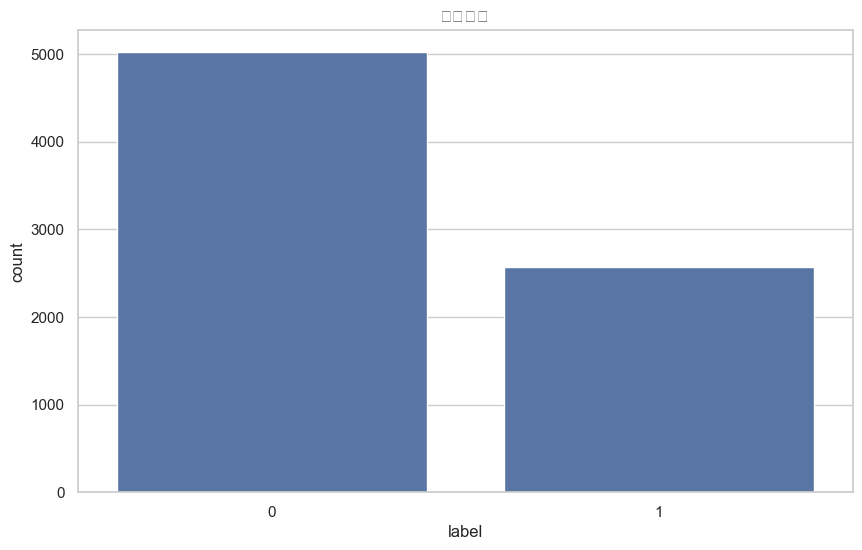


特徵統計摘要:
           x0           x1            x2      x3      x4      x5      x6  \
count  7597.0  7597.000000   7597.000000  7597.0  7597.0  7597.0  7597.0   
mean      0.0     0.274582    305.715019     0.0     0.0     0.0     0.0   
std       0.0     6.760801   1165.610749     0.0     0.0     0.0     0.0   
min       0.0     0.000000      0.000000     0.0     0.0     0.0     0.0   
25%       0.0     0.000000     18.000000     0.0     0.0     0.0     0.0   
50%       0.0     0.000000     93.000000     0.0     0.0     0.0     0.0   
75%       0.0     0.000000    244.000000     0.0     0.0     0.0     0.0   
max       0.0   294.000000  28161.000000     0.0     0.0     0.0     0.0   

           x7      x8           x9     x10           x11     x12     x13  \
count  7597.0  7597.0  7597.000000  7597.0   7597.000000  7597.0  7597.0   
mean      0.0     0.0    14.337765     0.0    439.604054     0.0     0.0   
std       0.0     0.0    46.195813     0.0    844.380172     0.0     0.0   
mi

In [208]:
print("\n分析原始資料:")
analyze_features(train_data, test_data)

In [210]:
print("\n移除零方差特徵:")
train_cleaned, test_cleaned = remove_low_variance_features(train_data, test_data)
eval_cleaned = eval_data[train_cleaned.columns]


移除零方差特徵:
發現 267 個低方差特徵（非零值比例<0.01或全相同值）
原始特徵數量: 361
清理後特徵數量: 94



特徵值域分析:

特徵值域摘要:
最大值 > 1000 的特徵數量: 75
最大值 > 100 的特徵數量: 83
最大值 <= 10 的特徵數量: 2


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from font(s) Arial.
  fig.canvas.print_fig

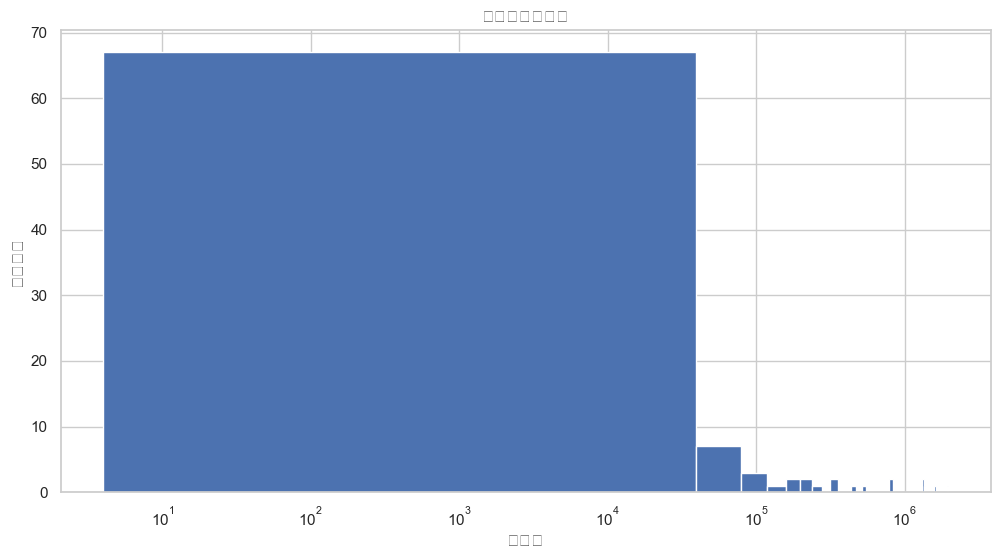

In [212]:
feature_ranges = analyze_value_ranges(train_cleaned)

In [214]:
print("\n進行特徵分箱:")
train_binned, test_binned = preprocess_data(train_cleaned, test_cleaned)
_, eval_binned = preprocess_data(train_cleaned, eval_cleaned)  # 使用training data的統計資訊
print(train_binned.shape)
print(test_binned.shape)
print(eval_binned.shape)


進行特徵分箱:
分箱後的樣本特徵分佈:

x2 分佈:
x2
very_low     1665
medium       1521
high         1517
very_high    1513
low          1381
Name: count, dtype: int64

x9 分佈:
x9
very_low     2041
high         1506
medium       1471
very_high    1456
low          1123
Name: count, dtype: int64

x11 分佈:
x11
very_low     1546
high         1520
very_high    1518
low          1510
medium       1503
Name: count, dtype: int64

x14 分佈:
x14
very_low    7534
low           58
medium         5
Name: count, dtype: int64

x15 分佈:
x15
very_low     1782
medium       1599
very_high    1510
high         1402
low          1304
Name: count, dtype: int64
分箱後的樣本特徵分佈:

x2 分佈:
x2
very_low     1665
medium       1521
high         1517
very_high    1513
low          1381
Name: count, dtype: int64

x9 分佈:
x9
very_low     2041
high         1506
medium       1471
very_high    1456
low          1123
Name: count, dtype: int64

x11 分佈:
x11
very_low     1546
high         1520
very_high    1518
low          1510
medium       1503
Name: co

In [216]:
print("\n儲存處理後的資料...")
train_binned.to_csv('data/preprocessed_train.csv', index=False)
test_binned.to_csv('data/preprocessed_test.csv', index=False)
eval_binned.to_csv('data/preprocessed_eval.csv', index=False)

print("完成！預處理後的資料已儲存")


儲存處理後的資料...
完成！預處理後的資料已儲存


In [218]:
def load_preprocessed_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """載入預處理後的資料"""
    try:
        train_data = pd.read_csv('data/preprocessed_train.csv')
        test_data = pd.read_csv('data/preprocessed_test.csv')
        print(f"載入資料成功!")
        print(f"訓練集大小: {train_data.shape}")
        print(f"測試集大小: {test_data.shape}")
        return train_data, test_data
    except Exception as e:
        print(f"載入資料時發生錯誤: {e}")
        raise

In [220]:
train_data, test_data = load_preprocessed_data()

載入資料成功!
訓練集大小: (7597, 95)
測試集大小: (2531, 95)


In [222]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import time

In [224]:
def prepare_data(train_data: pd.DataFrame, test_data: pd.DataFrame) -> Tuple[pd.DataFrame, list, pd.DataFrame, list]:
    """準備訓練和測試資料"""
    train_x = train_data.drop('label', axis=1)
    train_y = train_data['label'].tolist()
    test_x = test_data.drop('label', axis=1)
    test_y = test_data['label'].tolist()
    return train_x, train_y, test_x, test_y

In [226]:
def prepare_sklearn_data(train_data: pd.DataFrame, test_data: pd.DataFrame):
    """準備用於sklearn模型的訓練和測試資料"""
    # 提取特徵和標籤
    train_x = train_data.drop('label', axis=1)
    train_y = train_data['label']
    test_x = test_data.drop('label', axis=1)
    test_y = test_data['label']
    
    # 找出所有類別型特徵
    categorical_features = []
    for col in train_x.columns:
        if train_x[col].dtype == 'object':
            categorical_features.append(col)
    
    print(f"發現 {len(categorical_features)} 個類別型特徵")
    
    # 使用One-Hot編碼處理類別型特徵
    # 這樣可以避免LabelEncoder的問題，並可處理訓練集和測試集中不同的類別值
    train_x_encoded = pd.get_dummies(train_x, drop_first=False)
    test_x_encoded = pd.get_dummies(test_x, drop_first=False)
    
    # 確保訓練集和測試集有相同的特徵
    common_columns = set(train_x_encoded.columns) & set(test_x_encoded.columns)
    print(f"編碼後共有 {len(common_columns)} 個共同特徵")
    
    # 只保留訓練集和測試集都有的特徵
    train_x_final = train_x_encoded[list(common_columns)]
    test_x_final = test_x_encoded[list(common_columns)]
    
    return train_x_final, train_y, test_x_final, test_y

# 準備sklearn資料
train_x, train_y, test_x, test_y = prepare_sklearn_data(train_data, test_data)

print(f"訓練特徵形狀: {train_x.shape}")
print(f"測試特徵形狀: {test_x.shape}")

# 檢視前幾個特徵名稱
print("\n前5個特徵名稱:")
print(list(train_x.columns)[:5])

發現 92 個類別型特徵
編碼後共有 397 個共同特徵
訓練特徵形狀: (7597, 397)
測試特徵形狀: (2531, 397)

前5個特徵名稱:
['x201_high', 'x11_low', 'x37_low', 'x26_very_high', 'x66_low']



訓練 決策樹 (默認參數)...
訓練時間: 0.16 秒
訓練集準確率: 0.984
測試集準確率: 0.874

分類報告:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1674
           1       0.80      0.84      0.82       857

    accuracy                           0.87      2531
   macro avg       0.86      0.87      0.86      2531
weighted avg       0.88      0.87      0.88      2531



/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) missing from font(s) Arial.
  fig.canvas.print_fig

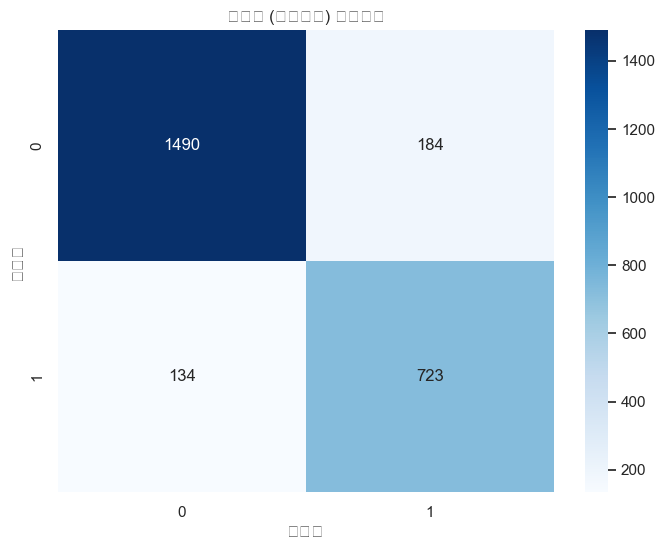

In [228]:
def train_and_evaluate_sklearn_model(model, train_x, train_y, test_x, test_y, model_name):
    """訓練並評估sklearn模型"""
    print(f"\n訓練 {model_name}...")
    
    # 記錄訓練開始時間
    start_time = time.time()
    
    # 訓練模型
    model.fit(train_x, train_y)
    
    # 計算訓練時間
    training_time = time.time() - start_time
    
    # 進行預測
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)
    
    # 計算準確率
    train_accuracy = accuracy_score(train_y, train_pred)
    test_accuracy = accuracy_score(test_y, test_pred)
    
    results = {
        'model_name': model_name,
        'training_time': round(training_time, 2),
        'train_accuracy': round(train_accuracy, 3),
        'test_accuracy': round(test_accuracy, 3)
    }
    
    print(f"訓練時間: {training_time:.2f} 秒")
    print(f"訓練集準確率: {train_accuracy:.3f}")
    print(f"測試集準確率: {test_accuracy:.3f}")
    
    # 顯示詳細評估報告
    print("\n分類報告:")
    print(classification_report(test_y, test_pred))
    
    # 視覺化混淆矩陣
    cm = confusion_matrix(test_y, test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} 混淆矩陣')
    plt.ylabel('實際值')
    plt.xlabel('預測值')
    plt.show()
    
    return results

# %%
# 訓練決策樹模型
dt_model = DecisionTreeClassifier(random_state=42)
dt_results = train_and_evaluate_sklearn_model(
    dt_model, train_x, train_y, test_x, test_y, "決策樹 (默認參數)"
)

In [230]:
def experiment_with_tree_depths(train_x, train_y, test_x, test_y, depth_range):
    """嘗試不同深度的決策樹"""
    results = []
    best_accuracy = 0
    best_depth = None
    
    print("\n開始測試不同深度的決策樹...")
    
    for depth in depth_range:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model_name = f"決策樹 (深度={depth})"
        
        # 訓練開始時間
        start_time = time.time()
        
        # 訓練模型
        model.fit(train_x, train_y)
        
        # 計算訓練時間
        training_time = time.time() - start_time
        
        # 評估模型
        train_pred = model.predict(train_x)
        test_pred = model.predict(test_x)
        
        train_accuracy = accuracy_score(train_y, train_pred)
        test_accuracy = accuracy_score(test_y, test_pred)
        
        result = {
            'depth': depth,
            'training_time': round(training_time, 2),
            'train_accuracy': round(train_accuracy, 3),
            'test_accuracy': round(test_accuracy, 3)
        }
        
        results.append(result)
        print(f"深度 {depth}: 訓練準確率 = {train_accuracy:.3f}, 測試準確率 = {test_accuracy:.3f}")
        
        # 更新最佳模型
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_depth = depth
    
    return {
        'all_results': results,
        'best_depth': best_depth,
        'best_accuracy': best_accuracy
    }

# %%
# 實驗不同深度的決策樹
depth_results = experiment_with_tree_depths(
    train_x, train_y, test_x, test_y,
    depth_range=range(3, 21, 2)  # 測試深度 3, 5, 7, ..., 19
)


開始測試不同深度的決策樹...
深度 3: 訓練準確率 = 0.795, 測試準確率 = 0.785
深度 5: 訓練準確率 = 0.833, 測試準確率 = 0.812
深度 7: 訓練準確率 = 0.877, 測試準確率 = 0.846
深度 9: 訓練準確率 = 0.913, 測試準確率 = 0.864
深度 11: 訓練準確率 = 0.944, 測試準確率 = 0.866
深度 13: 訓練準確率 = 0.964, 測試準確率 = 0.869
深度 15: 訓練準確率 = 0.977, 測試準確率 = 0.868
深度 17: 訓練準確率 = 0.981, 測試準確率 = 0.870
深度 19: 訓練準確率 = 0.983, 測試準確率 = 0.876


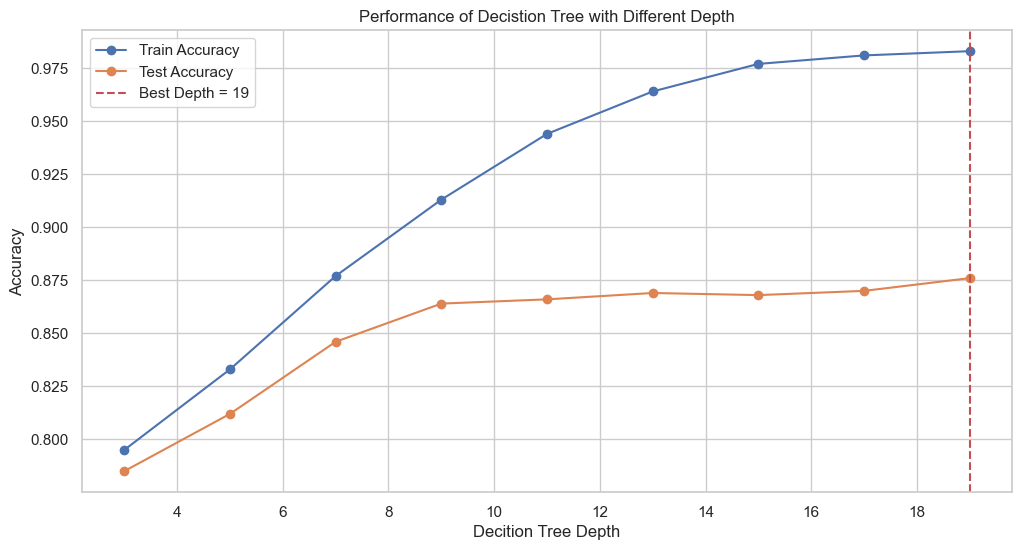

In [234]:
depths = [result['depth'] for result in depth_results['all_results']]
train_accuracies = [result['train_accuracy'] for result in depth_results['all_results']]
test_accuracies = [result['test_accuracy'] for result in depth_results['all_results']]

plt.figure(figsize=(12, 6))
plt.plot(depths, train_accuracies, 'o-', label='Train Accuracy')
plt.plot(depths, test_accuracies, 'o-', label='Test Accuracy')
plt.axvline(x=depth_results['best_depth'], color='r', linestyle='--', 
            label=f'Best Depth = {depth_results["best_depth"]}')
plt.xlabel('Decition Tree Depth')
plt.ylabel('Accuracy')
plt.title('Performance of Decistion Tree with Different Depth')
plt.legend()
plt.grid(True)
plt.show()


使用最佳深度 19 訓練最終決策樹模型...

訓練 最佳決策樹 (深度=19)...
訓練時間: 0.16 秒
訓練集準確率: 0.983
測試集準確率: 0.876

分類報告:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1674
           1       0.80      0.84      0.82       857

    accuracy                           0.88      2531
   macro avg       0.86      0.87      0.86      2531
weighted avg       0.88      0.88      0.88      2531



/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) missing from font(s) Arial.
  fig.canvas.print_fig

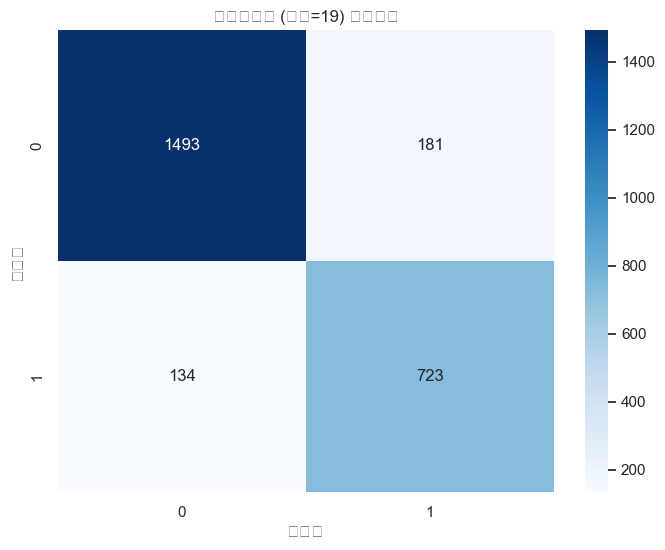

In [236]:
print(f"\n使用最佳深度 {depth_results['best_depth']} 訓練最終決策樹模型...")
best_dt_model = DecisionTreeClassifier(max_depth=depth_results['best_depth'], random_state=42)
best_dt_results = train_and_evaluate_sklearn_model(
    best_dt_model, train_x, train_y, test_x, test_y,
    f"最佳決策樹 (深度={depth_results['best_depth']})"
)


訓練 隨機森林 (100棵樹)...
訓練時間: 0.79 秒
訓練集準確率: 0.984
測試集準確率: 0.913

分類報告:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1674
           1       0.89      0.84      0.87       857

    accuracy                           0.91      2531
   macro avg       0.91      0.90      0.90      2531
weighted avg       0.91      0.91      0.91      2531



/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) missing from font(s) Arial.
  fig.canvas.print_fig

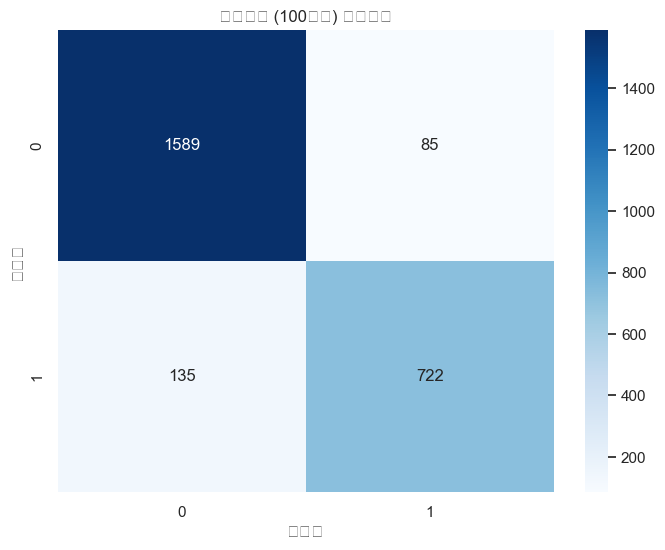

In [238]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = train_and_evaluate_sklearn_model(
    rf_model, train_x, train_y, test_x, test_y, "隨機森林 (100棵樹)"
)

In [240]:
def experiment_with_random_forest(train_x, train_y, test_x, test_y):
    """測試不同參數的隨機森林"""
    results = []
    best_accuracy = 0
    best_params = None
    
    print("\n開始測試不同參數的隨機森林...")
    
    # 測試不同數量的樹
    n_estimators_list = [50, 100, 200]
    # 測試不同的最大深度
    max_depth_list = [None, 10, 20]
    # 測試不同的最小分割樣本數
    min_samples_split_list = [2, 5, 10]
    
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            for min_samples_split in min_samples_split_list:
                # 只測試部分組合以節省時間
                if n_estimators == 100 or max_depth == 10 or min_samples_split == 5:
                    model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        random_state=42
                    )
                    
                    model_name = f"RF(trees={n_estimators}, depth={max_depth}, min_samples={min_samples_split})"
                    
                    # 訓練開始時間
                    start_time = time.time()
                    
                    # 訓練模型
                    model.fit(train_x, train_y)
                    
                    # 計算訓練時間
                    training_time = time.time() - start_time
                    
                    # 評估模型
                    test_pred = model.predict(test_x)
                    test_accuracy = accuracy_score(test_y, test_pred)
                    
                    result = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'training_time': round(training_time, 2),
                        'test_accuracy': round(test_accuracy, 3)
                    }
                    
                    results.append(result)
                    print(f"{model_name}: 測試準確率 = {test_accuracy:.3f}, 訓練時間 = {training_time:.2f}秒")
                    
                    # 更新最佳模型
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split
                        }
    
    return {
        'all_results': results,
        'best_params': best_params,
        'best_accuracy': best_accuracy
    }

# %%
# 實驗不同參數的隨機森林
rf_param_results = experiment_with_random_forest(train_x, train_y, test_x, test_y)


開始測試不同參數的隨機森林...
RF(trees=50, depth=None, min_samples=5): 測試準確率 = 0.910, 訓練時間 = 0.40秒
RF(trees=50, depth=10, min_samples=2): 測試準確率 = 0.879, 訓練時間 = 0.27秒
RF(trees=50, depth=10, min_samples=5): 測試準確率 = 0.878, 訓練時間 = 0.26秒
RF(trees=50, depth=10, min_samples=10): 測試準確率 = 0.877, 訓練時間 = 0.25秒
RF(trees=50, depth=20, min_samples=5): 測試準確率 = 0.906, 訓練時間 = 0.33秒
RF(trees=100, depth=None, min_samples=2): 測試準確率 = 0.913, 訓練時間 = 0.71秒
RF(trees=100, depth=None, min_samples=5): 測試準確率 = 0.911, 訓練時間 = 0.69秒
RF(trees=100, depth=None, min_samples=10): 測試準確率 = 0.904, 訓練時間 = 0.66秒
RF(trees=100, depth=10, min_samples=2): 測試準確率 = 0.883, 訓練時間 = 0.50秒
RF(trees=100, depth=10, min_samples=5): 測試準確率 = 0.879, 訓練時間 = 0.50秒
RF(trees=100, depth=10, min_samples=10): 測試準確率 = 0.876, 訓練時間 = 0.49秒
RF(trees=100, depth=20, min_samples=2): 測試準確率 = 0.915, 訓練時間 = 0.68秒
RF(trees=100, depth=20, min_samples=5): 測試準確率 = 0.908, 訓練時間 = 0.67秒
RF(trees=100, depth=20, min_samples=10): 測試準確率 = 0.903, 訓練時間 = 0.62秒
RF(trees=200, depth=Non

In [242]:
rf_results_df = pd.DataFrame(rf_param_results['all_results'])

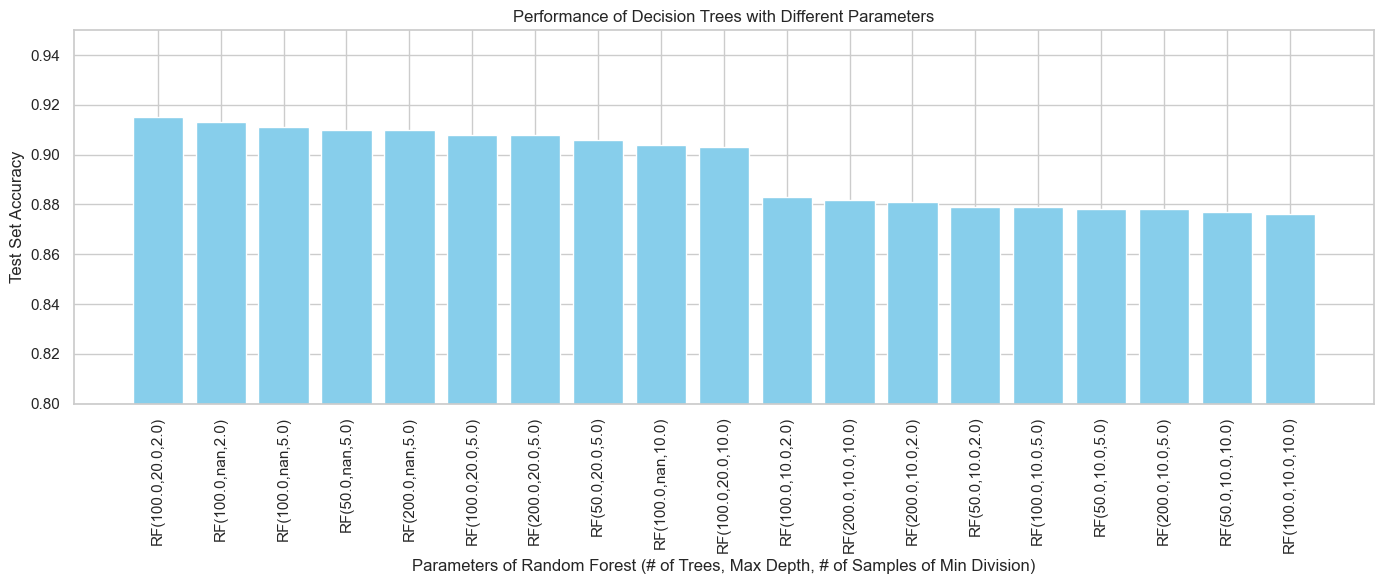

In [246]:
rf_results_df = rf_results_df.sort_values('test_accuracy', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(range(len(rf_results_df)), rf_results_df['test_accuracy'], color='skyblue')
plt.xticks(range(len(rf_results_df)), 
           [f"RF({r['n_estimators']},{str(r['max_depth'])},{r['min_samples_split']})" 
            for _, r in rf_results_df.iterrows()], 
           rotation=90)
plt.ylim(0.8, 0.95)
plt.xlabel('Parameters of Random Forest (# of Trees, Max Depth, # of Samples of Min Division)')
plt.ylabel('Test Set Accuracy')
plt.title('Performance of Decision Trees with Different Parameters')
plt.tight_layout()
plt.show()


使用最佳參數訓練最終隨機森林模型...
最佳參數: 樹數量=100, 最大深度=20, 最小分割樣本數=2

訓練 最佳隨機森林...
訓練時間: 0.72 秒
訓練集準確率: 0.982
測試集準確率: 0.915

分類報告:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1674
           1       0.90      0.85      0.87       857

    accuracy                           0.92      2531
   macro avg       0.91      0.90      0.90      2531
weighted avg       0.91      0.92      0.91      2531



/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) missing from font(s) Arial.
  fig.canvas.print_fig

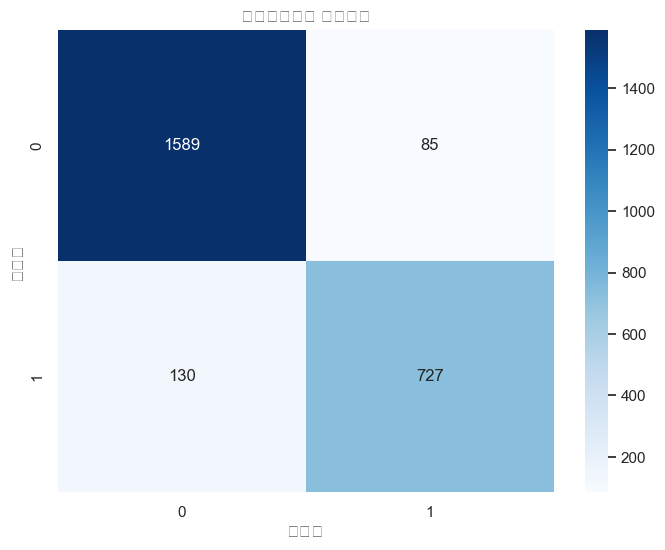

In [248]:
best_params = rf_param_results['best_params']
print(f"\n使用最佳參數訓練最終隨機森林模型...")
print(f"最佳參數: 樹數量={best_params['n_estimators']}, 最大深度={best_params['max_depth']}, 最小分割樣本數={best_params['min_samples_split']}")

best_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

best_rf_results = train_and_evaluate_sklearn_model(
    best_rf_model, train_x, train_y, test_x, test_y, "最佳隨機森林"
)

In [250]:
def plot_feature_importance(model, feature_names, top_n=20):
    """繪製特徵重要性圖"""
    # 獲取特徵重要性
    importances = model.feature_importances_
    
    # 創建特徵重要性的DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # 排序並取前N個最重要的特徵
    top_features = feature_importance_df.sort_values('importance', ascending=False).head(top_n)
    
    # 繪製條形圖
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title(f'前{top_n}個最重要的特徵')
    plt.tight_layout()
    plt.show()

決策樹模型的特徵重要性:


/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/ipykernel_26505/1779945889.py:19: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/ipykernel_26505/1779945889.py:19: UserWarning: Glyph 20491 (\N{CJK UNIFIED IDEOGRAPH-500B}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/ipykernel_26505/1779945889.py:19: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/ipykernel_26505/1779945889.py:19: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/ipykernel_26505/1779945889.py:19: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/i

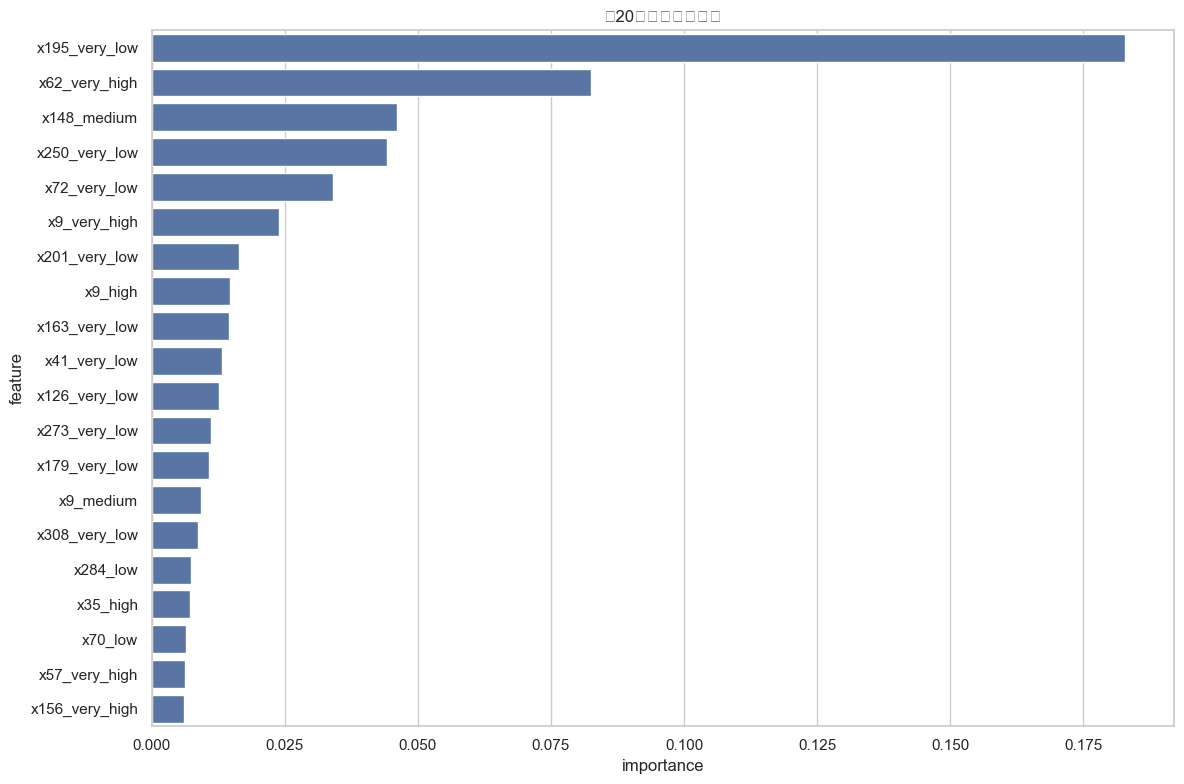

In [252]:
print("決策樹模型的特徵重要性:")
plot_feature_importance(best_dt_model, train_x.columns)


隨機森林模型的特徵重要性:


/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/ipykernel_26505/1779945889.py:19: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/ipykernel_26505/1779945889.py:19: UserWarning: Glyph 20491 (\N{CJK UNIFIED IDEOGRAPH-500B}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/ipykernel_26505/1779945889.py:19: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/ipykernel_26505/1779945889.py:19: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/ipykernel_26505/1779945889.py:19: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1b/ytdw0wgj6yj_fg86mtzrbjd00000gn/T/i

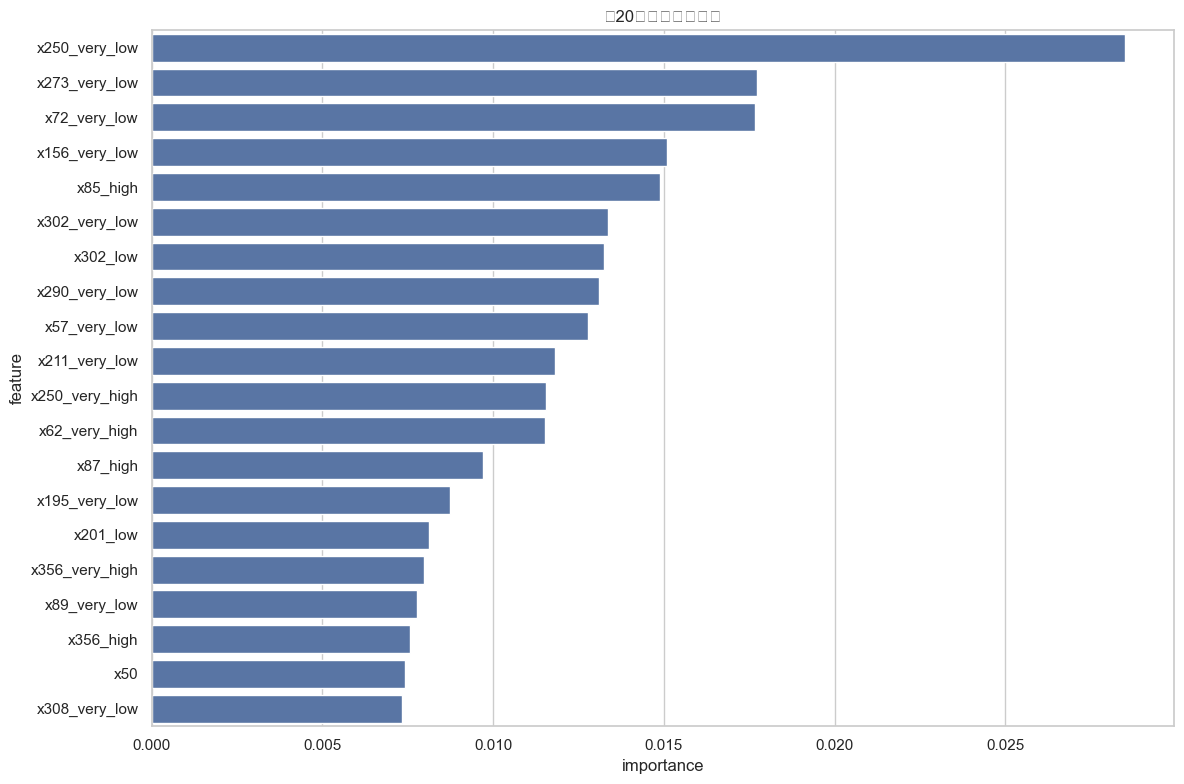

In [254]:
print("\n隨機森林模型的特徵重要性:")
plot_feature_importance(best_rf_model, train_x.columns)

In [256]:
models_comparison = {
    'DT (Default)': dt_results,
    f'Best DT (Depth={depth_results["best_depth"]})': best_dt_results,
    'RF (100 Trees)': rf_results,
    'Best RF': best_rf_results
}

In [258]:
comparison_data = []
for model_name, results in models_comparison.items():
    comparison_data.append({
        'Model': model_name,
        'Train Accuracy': results['train_accuracy'],
        'Test Accuracy': results['test_accuracy'],
        'Training Time (sec)': results['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
display(comparison_df)

Model Comparison:


,Model,Train Accuracy,Test Accuracy,Training Time (sec)
0,DT (Default),0.984,0.874,0.16
1,Best DT (Depth=19),0.983,0.876,0.16
2,RF (100 Trees),0.984,0.913,0.79
3,Best RF,0.982,0.915,0.72


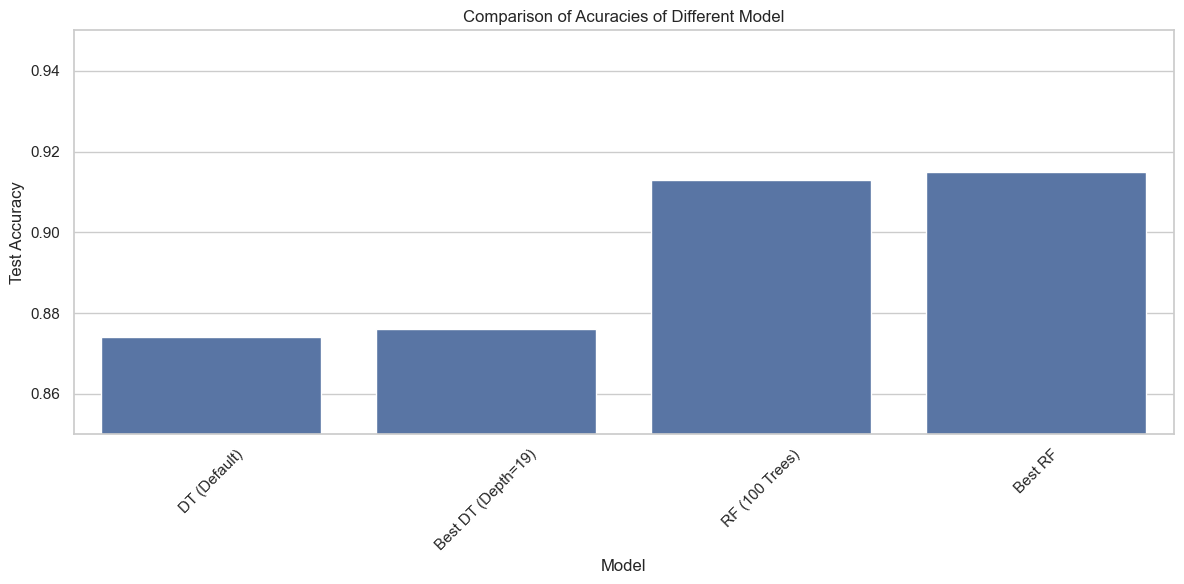

In [260]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Test Accuracy', data=comparison_df)
plt.title('Comparison of Acuracies of Different Model')
plt.ylim(0.85, 0.95)  # 設定y軸範圍以更好地顯示差異
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [272]:
try:
    eval_data = pd.read_csv('data/preprocessed_eval.csv')
    eval_ids = pd.read_csv('data/eval.id', header=None)
    eval_ids.columns = ['example_id']
    print(f"載入ID檔案成功!")
    print(f"ID檔案大小: {eval_data.shape}")
    print(f"ID檔案大小: {eval_ids.shape}")
except Exception as e:
    print(f"載入ID檔案時發生錯誤: {e}")
    raise

載入ID檔案成功!
ID檔案大小: (2532, 95)
ID檔案大小: (2532, 1)


In [274]:
eval_x = eval_data.drop('label', axis=1)

# 與訓練資料進行相同的編碼處理
eval_x_encoded = pd.get_dummies(eval_x, drop_first=False)

# 確保與訓練資料有相同的特徵
missing_cols = set(train_x.columns) - set(eval_x_encoded.columns)
for col in missing_cols:
    eval_x_encoded[col] = 0
eval_x_final = eval_x_encoded[train_x.columns]

print(f"評估特徵形狀: {eval_x_final.shape}")
eval_x_final

評估特徵形狀: (2532, 397)


,x201_high,x11_low,x37_low,x26_very_high,x66_low,x258_high,x250_high,x200_low,x297_medium,x104_very_low,x42_very_low,x306_very_low,x87_very_high,x141_very_low,x99_very_low,x57_low,x81_very_low,x198_very_high,x62_very_low,x297_very_high,x96_very_low,x99_high,x254_high,x360_high,x200_high,x83_very_high,x356_very_high,x21_medium,x35_very_high,x249_high,x255_very_high,x238_low,x109_high,x302_low,x218_very_low,x306_high,x272,x53_high,x167_low,x163_very_low,x249_medium,x308_very_low,x2_high,x297_very_low,x126_very_low,x254_very_high,x290_low,x341_low,x66_very_low,x284_medium,x254_low,x15_high,x342_high,x291_very_low,x14_medium,x83_low,x144_very_high,x211_medium,x70_medium,x108_low,x198_very_low,x224_high,x250_very_low,x61_very_low,x108_high,x273_very_high,x236_high,x308_very_high,x57_high,x151_very_high,x195_very_low,x176_very_low,x9_high,x189_high,x297_low,x144_medium,x112_high,x30_very_high,x25_low,x342_low,x356_very_low,x96_medium,x258_low,x151_high,x41_very_low,x227_low,x342_very_low,x222_very_low,x9_very_high,x198_medium,x24_very_low,x163_very_high,x15_very_low,x89_very_high,x57_medium,x156_very_low,x62_high,x99_medium,x151_medium,x359_medium,x62_very_high,x26_medium,x200_medium,x292_very_high,x255_high,x144_high,x148_high,x83_medium,x300_medium,x107_high,x108_very_low,x249_very_low,x107_very_high,x11_very_high,x236_very_high,x338_high,x244_medium,x254_very_low,x30_very_low,x152_very_low,x215_low,x2_low,x300_very_low,x89_very_low,x227_very_high,x14_low,x89_medium,x14_very_low,x26_very_low,x322_low,x31_very_low,x109_medium,x25_very_low,x74_medium,x15_very_high,x61_medium,x211_very_high,x290_very_low,x189_low,x292_medium,x11_high,x148_very_low,x248_very_low,x35_very_low,x151_low,x135_very_high,x291_very_high,x24_very_high,x290_medium,x249_very_high,x238_medium,x109_very_low,x179_high,x85_high,x87_very_low,x31_very_high,x248_medium,x73_very_low,x81_very_high,x291_medium,x181_very_high,x96_low,x83_high,x179_medium,x308_medium,x126_medium,x222_medium,x25_medium,x37_very_low,x104_very_high,x2_very_low,x42_high,x224_very_high,x198_high,x74_very_low,x40_very_high,x110_high,x163_high,x179_very_high,x243_medium,x359_very_high,x21_very_high,x211_high,x224_extreme,x15_medium,x57_very_low,x40_very_low,x151_very_low,x306_low,x99_very_high,x222_low,x179_very_low,x112_low,x66_very_high,x24_low,x338_very_high,x35_high,x222_high,x342_medium,x290_extreme,x104_high,x195_low,x87_medium,x322_medium,x248_low,x248_very_high,x26_high,x341_very_low,x360_medium,x33_very_low,x359_high,x41_medium,x200_very_high,x273_very_low,x224_low,x222_very_high,x126_high,x2_medium,x244_high,x21_low,x73_low,x24_high,x231_very_low,x284_high,x112_very_high,x50,x244_very_low,x152_high,x181_medium,x300_very_high,x227_medium,x107_medium,x96_very_high,x254_medium,x181_low,x195_high,x195_very_high,x338_very_low,x201_very_low,x25_very_high,x89_high,x21_very_low,x231_low,x201_very_high,x302_very_low,x72_high,x110_very_low,x56_very_high,x227_very_low,x215_very_low,x292_low,x306_medium,x66_medium,x284_very_low,x9_medium,x30_low,x163_low,x85_very_low,x152_low,x227_high,x215_very_high,x110_low,x244_low,x238_very_low,x292_very_low,x53_medium,x156_low,x70_very_high,x360_very_high,x152_very_high,x2_very_high,x236_very_low,x300_high,x104_medium,x255_low,x243_low,x342_very_high,x189_very_high,x108_medium,x156_very_high,x41_high,x9_very_low,x56_low,x201_medium,x148_very_high,x83_very_low,x255_medium,x356_high,x30_high,x292_high,x42_very_high,x248_high,x15_low,x290_high,x255_very_low,x258_very_high,x56_high,x107_very_low,x74_very_high,x70_high,x167_very_low,x359_low,x25_high,x126_very_high,x243_very_low,x284_very_high,x167_very_high,x258_very_low,x110_medium,x215_high,x273_high,x250_very_high,x41_low,x126_low,x26_low,x41_very_high,x211_low,x224_very_low,x189_medium,x74_low,x72_very_low,x108_very_high,x306_very_high,x181_high,x201_low,x300_low,x258_medium,x24_medium,x70_very_low,x167_medium,x21_high,x156_high,x109_low,x87_high,x167_high,x53_very_low,x109_very_high,x224_medium,x156_medium,x9

In [276]:
print("使用最佳隨機森林模型進行預測...")
eval_predictions = best_rf_model.predict(eval_x_final)

# 計算預測為正例和負例的數量
positive_count = np.sum(eval_predictions == 1)
negative_count = np.sum(eval_predictions == 0)

print(f"預測為正例 (惡意軟體) 的數量: {positive_count}")
print(f"預測為負例 (正常軟體) 的數量: {negative_count}")
print(f"正例比例: {positive_count / len(eval_predictions):.2f}")

使用最佳隨機森林模型進行預測...
預測為正例 (惡意軟體) 的數量: 829
預測為負例 (正常軟體) 的數量: 1703
正例比例: 0.33


In [278]:
submission = pd.DataFrame({
    'example_id': eval_ids['example_id'],
    'label': eval_predictions
})

In [280]:
submission.to_csv('submission_rf.csv', index=False)
print("預測結果已儲存為 'submission_rf.csv'")

預測結果已儲存為 'submission_rf.csv'
